# Star Trek Uniform Classifier - CNN

* Collect images of Star Trek uniforms
    * Red, Blue, Gold

In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input
from keras.utils import to_categorical
from keras.layers import Conv2D # to add convolutional layers
from keras.layers import MaxPooling2D # to add pooling layers
from keras.layers import Flatten # to flatten data for fully connected layers
import os
from pathlib import Path
from PIL import Image

# Load data

In [51]:
# define data path and categories
data_dir = Path('rawData')
categories = ['commandRed', 'scienceBlue', 'operationGold']

In [20]:
# function to handle images
def clean_and_verify_data(base_path, folder_list):

    # iterate through categires
    for category in folder_list:
        path = base_path / category
        print(f"==== Checking for: {category} ====")

        files = list(path.glob('*'))
        for file_path in files:
            # remove everything except jpg, jpeg and png
            if file_path.suffix.lower() not in ['.jpg', '.jpeg', '.png']:
                print(f"Revoming: {file_path.name}")
                file_path.unlink()
                continue

            try:
                # try open img to check for corruption
                with Image.open(file_path) as img:
                    img.verify() # verify whether its img

                # convert to RBG in case more channels
                with Image.open(file_path) as img:
                    img = img.convert('RGB')
                    img = img.resize((128, 128)) # resize img 
                    img.save(file_path) # overwrite !!

            except (IOError, SyntaxError) as e:
                print(f"Deleting file: {file_path.name}")
                file_path.unlink()


In [21]:
clean_and_verify_data(data_dir, categories)

==== Checking for: commandRed ====
Revoming: download (13).svg
Revoming: imgi_403_831a5d31c83ad3e3b8981170c290e73ec09ce812_2000x2000.webp
Revoming: download (6).svg
Revoming: download (25).svg
Revoming: imgi_396_PBA-014817_1.webp
Revoming: download (24).svg
Revoming: download (7).svg
Revoming: download (12).svg
Revoming: imgi_448_250.webp
Revoming: download (28).svg
Revoming: download (23).svg
Revoming: download (19).svg
Revoming: download (15).svg
Revoming: download.svg
Revoming: download (14).svg
Revoming: download (18).svg
Revoming: imgi_377_mspin_googcolor_medium.svg
Revoming: download (22).svg
Revoming: download (1).svg
Revoming: imgi_443_460980-large_default.webp
Revoming: imgi_12_24px.svg
Revoming: download (21).svg
Revoming: download (2).svg
Revoming: download (17).svg
Revoming: download (16).svg
Revoming: imgi_427_Y1r0mxAiRNy_Z5TGfDtfCw.webp
Revoming: imgi_389_TEk83bOoRkee4-wR3cgp2A.webp
Revoming: imgi_421_Next-Generation-Star-Trek-Picard-Suede-Leather-Jacket.webp
Revoming: do

# Normalize data and split

In [52]:
from keras import layers
# constants
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

# load and split
train_ds = keras.utils.image_dataset_from_directory(
    'rawData',
    validation_split=0.2, # 20% for testing
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

val_ds = keras.utils.image_dataset_from_directory(
    'rawData',
    validation_split=0.2, # 20% for validation
    subset='validation',
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

# save classes name for debug
class_names = train_ds.class_names
print(f"Classes found: {class_names}")

# normalize
normalization_layer = layers.Rescaling(1./255)

# apply to dataset
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

Found 787 files belonging to 3 classes.
Using 630 files for training.
Found 787 files belonging to 3 classes.
Using 157 files for validation.
Classes found: ['commandRed', 'operationGold', 'scienceBlue']


# Veryfing if data is GOOD

## Visual verification

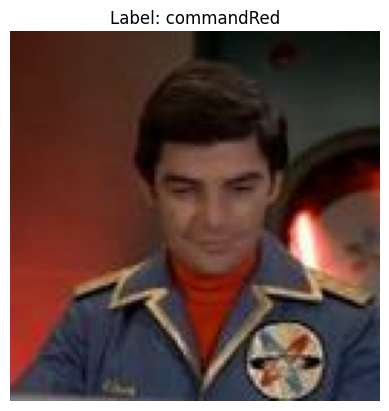

Max pixel value: 1.0
Min pixel value: 0.0


In [56]:
import matplotlib.pyplot as plt
import numpy as np

# take one batch from ds
for images, labels in train_ds.take(1):
    # images is a tensor of shape (32, 128, 128, 3)
    # labels is a tensor of shape (32, 3)
    
    first_image = images[0].numpy()
    first_label = labels[0].numpy()
    
    plt.imshow(first_image)
    plt.title(f"Label: {class_names[np.argmax(first_label)]}")
    plt.axis('off')
    plt.show()

    # print pixel range (max should be 1 and min should be 0)
    print(f"Max pixel value: {np.max(first_image)}")
    print(f"Min pixel value: {np.min(first_image)}")

## Shape verification

In [57]:
for images, labels in train_ds.take(1):
    print(f"Image batch shape: {images.shape}") # expect (32, 128, 128, 3), batch size, height, widht, channel numb RGB
    print(f"Label batch shape: {labels.shape}") # expect (32, 3)
    break

Image batch shape: (32, 128, 128, 3)
Label batch shape: (32, 3)


## Class balance verification - after cleaning

In [58]:
for category in class_names:
    path = f'rawData/{category}'
    print(f"{category}: {len(os.listdir(path))} images")

commandRed: 293 images
operationGold: 217 images
scienceBlue: 280 images


* operationGold is a bit smaller. **NEED TO AUGMENTATION** 

## Normalization check

In [59]:
for images, labels in train_ds.take(1):
    print(f"Data type: {images.dtype}") 
    print(f"First pixel value: {images[0, 0, 0, 0].numpy()}")
# expect float32

Data type: <dtype: 'float32'>
First pixel value: 0.9725490808486938


# Building Convolutional Neural Network

In [60]:
# building the model

# augmentation
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

def star_trek_cnn_model():
    '''
    input
    3 Conv2D / Maxpooling layers; relu
    flatten
    dense; relu
    regularization
    output, dense; softmax to probabilities
    '''
    model = keras.Sequential([
        # input
        layers.Input(shape=(128, 128, 3)),

        # data aug
        data_augmentation,

        # first layer, edges
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),

        # second layer, shapes
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),

        # third layer, complex patterns
        layers.Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2,2)),

        # output layer
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(3, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [61]:
# init and run model
model = star_trek_cnn_model()
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_10 (Sequential)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,027 (12.61 MB)

 Trainable params: 3,305,027 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

# Training Model

In [62]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    verbose=1
)

Epoch 1/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.5016 - loss: 1.0422 - val_accuracy: 0.7070 - val_loss: 0.6831
Epoch 2/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.7635 - loss: 0.5815 - val_accuracy: 0.8408 - val_loss: 0.4571
Epoch 3/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.8302 - loss: 0.4368 - val_accuracy: 0.8089 - val_loss: 0.4042
Epoch 4/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.8508 - loss: 0.4374 - val_accuracy: 0.8917 - val_loss: 0.3998
Epoch 5/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.8651 - loss: 0.4119 - val_accuracy: 0.9045 - val_loss: 0.3660
Epoch 6/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.8730 - loss: 0.3908 - val_accuracy: 0.8471 - val_loss: 0.4188
Epoch 7/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.8667 - loss: 0.4196 - val_accuracy: 0.8854 - val_loss: 0.3875
Epoch 8/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - accuracy: 0.8746 - loss: 0.3705 - val_accuracy: 0.8

In [63]:
scores = model.evaluate(val_ds, verbose=0)
print(f"Test Accuracy: {scores[1]:.4f}")
print(f"Test Loss: {scores[0]:.4f}")

Test Accuracy: 0.8981
Test Loss: 0.3372


# Using a pretrained Model

In [64]:
local_weights_path = 'mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_128_no_top.h5'

## Trying MobileNetV2

In [65]:
# transfer learning
base_model = keras.applications.MobileNetV2(
    weights=local_weights_path,
    input_shape=(128, 128, 3),
    include_top=False
)

# freeze the base model
base_model.trainable = False

model = keras.Sequential([
    layers.Input(shape=(128, 128, 3)),
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(), # flatten 3D data into 1D
    layers.Dropout(0.2),
    layers.Dense(3, activation='softmax') 
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [66]:
# train again
history_transfer = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    verbose=1
)

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 0.4095 - loss: 1.3551 - val_accuracy: 0.4968 - val_loss: 1.0164
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.5746 - loss: 0.9328 - val_accuracy: 0.6369 - val_loss: 0.8300
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.6714 - loss: 0.7667 - val_accuracy: 0.6879 - val_loss: 0.7296
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.7095 - loss: 0.6650 - val_accuracy: 0.7134 - val_loss: 0.6943
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.7333 - loss: 0.5725 - val_accuracy: 0.7452 - val_loss: 0.6650
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.7825 - loss: 0.5322 - val_accuracy: 0.7197 - val_loss: 0.6654
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.8254 - loss: 0.4706 - val_accuracy: 0.7261 - val_loss: 0.6438
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.8333 - loss: 0.4626 - val_accuracy: 0.7452 - 

* worse than model built from scratch
    * need to unfreeze small bit of pretrained model

In [67]:
# unfreeze base model
base_model.trainable = True

# print(f"Number of layers in base model: {len(base_model.layers)}")
# base model has 154 layers

fine_tune_at = 130 # freeze everything except the last 20 layers

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# recompile // low learning rate
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [68]:
fine_tune_epochs = 15
total_epochs = 20 + fine_tune_epochs

history_fine_tune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=history_transfer.epoch[-1], # start from left off
    verbose=1
)

Epoch 20/35
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step - accuracy: 0.7968 - loss: 0.5399 - val_accuracy: 0.7580 - val_loss: 0.6206
Epoch 21/35
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.8032 - loss: 0.5345 - val_accuracy: 0.7516 - val_loss: 0.6279
Epoch 22/35
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.8238 - loss: 0.4544 - val_accuracy: 0.7643 - val_loss: 0.6267
Epoch 23/35
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.8397 - loss: 0.4118 - val_accuracy: 0.7643 - val_loss: 0.6306
Epoch 24/35
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.8238 - loss: 0.4392 - val_accuracy: 0.7707 - val_loss: 0.6408
Epoch 25/35
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.8556 - loss: 0.3696 - val_accuracy: 0.7707 - val_loss: 0.6547
Epoch 26/35
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.8651 - loss: 0.3508 - val_accuracy: 0.7643 - val_loss: 0.6585
Epoch 27/35
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.8825 - loss: 0.3654 - val_accuracy: 0

* Accuracy 90%
* Validation accuracy 75%
* overfitting!

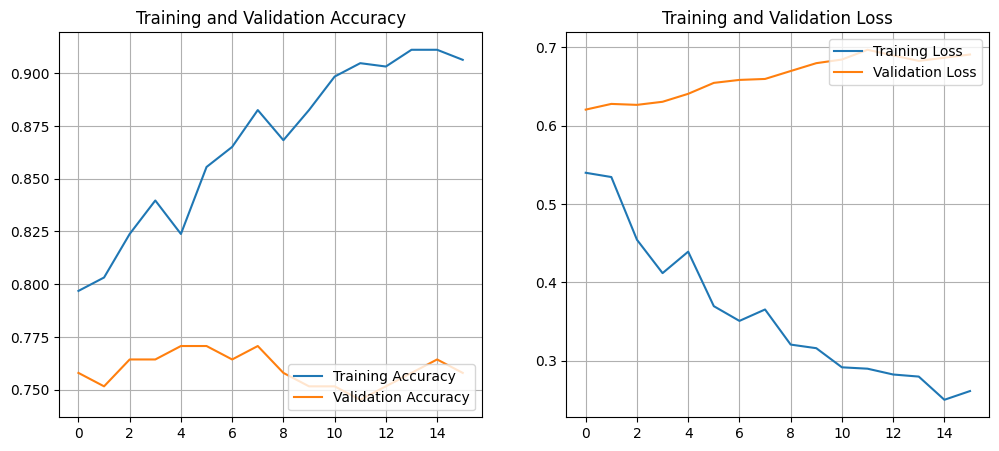

In [69]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))
    
    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.show()

plot_history(history_fine_tune) # Use the history from your fine-tuning step

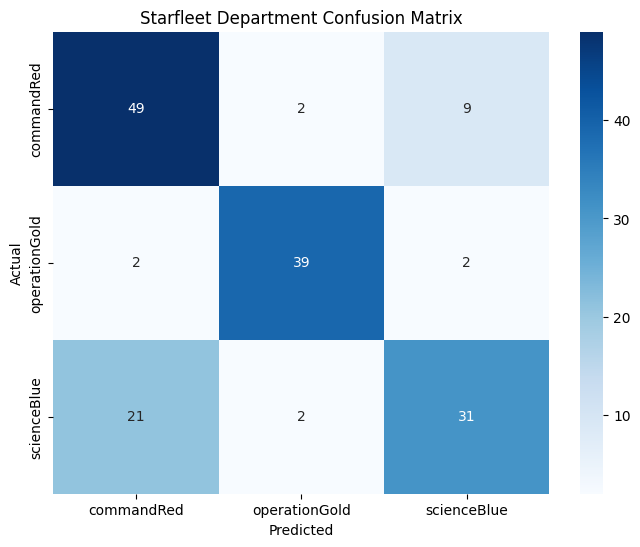

               precision    recall  f1-score   support

   commandRed       0.68      0.82      0.74        60
operationGold       0.91      0.91      0.91        43
  scienceBlue       0.74      0.57      0.65        54

     accuracy                           0.76       157
    macro avg       0.78      0.77      0.77       157
 weighted avg       0.76      0.76      0.75       157



In [70]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(np.argmax(labels, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# 2. Generate Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Starfleet Department Confusion Matrix')
plt.show()

# 3. Scientific Metrics Report
print(classification_report(y_true, y_pred, target_names=class_names))

* Model is memorizing = overfitting. Training loss decrease while Validation loss increases
* "commandRed" class precision is 0.53
* scienceBlue f1-score is 0.61
* the model guessed commandRed for 39 instances of that actually were scienceBlue
-----
* increase dropout
* L2 regularization

In [71]:
from keras import regularizers
# make the images change to avoid memorizing
data_augmentation.add(layers.RandomContrast(0.2))

# update final layers
model = keras.Sequential([
    layers.Input(shape=(128, 128, 3)),
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),

    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])

In [72]:
# re compile
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.00001), 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# early stop callback. If val loss do not 
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Red: 410, Gold: 278, Blue: 396
total = 410 + 278 + 396
class_weight = {
    0: (1 / 410) * (total / 3.0), # red
    1: (1 / 278) * (total / 3.0), # gold
    2: (1 / 396) * (total / 3.0)  # blue
}

# fit with updated callback and weight
history_final = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50, 
    class_weight=class_weight, 
    callbacks=[early_stop],    
    verbose=1
)

Epoch 1/50


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 0.3730 - loss: 3.7018 - val_accuracy: 0.3885 - val_loss: 3.5481
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.4111 - loss: 3.6088 - val_accuracy: 0.4013 - val_loss: 3.4568
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.4365 - loss: 3.4976 - val_accuracy: 0.4522 - val_loss: 3.3878
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.4921 - loss: 3.4240 - val_accuracy: 0.5350 - val_loss: 3.3264
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.5127 - loss: 3.3606 - val_accuracy: 0.5478 - val_loss: 3.2789
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.5413 - loss: 3.3071 - val_accuracy: 0.5605 - val_loss: 3.2400
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.5587 - loss: 3.2516 - val_accuracy: 0.5796 - val_loss: 3.2030
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.5921 - loss: 3.2077 - val_accuracy: 0.5924 - val_loss: 3

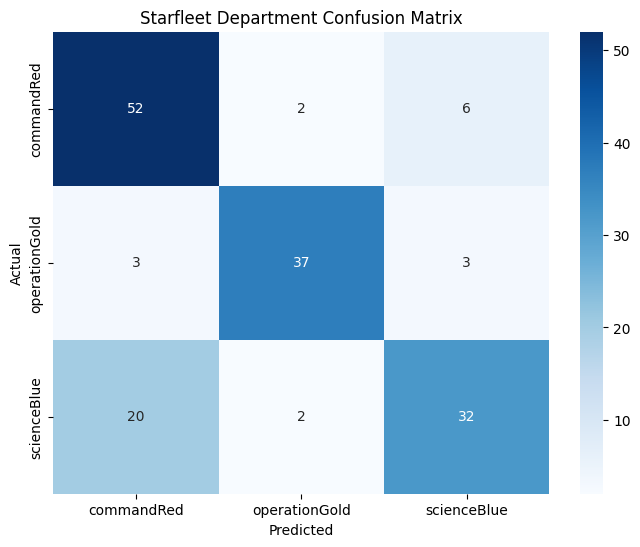

               precision    recall  f1-score   support

   commandRed       0.69      0.87      0.77        60
operationGold       0.90      0.86      0.88        43
  scienceBlue       0.78      0.59      0.67        54

     accuracy                           0.77       157
    macro avg       0.79      0.77      0.78       157
 weighted avg       0.78      0.77      0.77       157



In [74]:
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(np.argmax(labels, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Starfleet Department Confusion Matrix')
plt.show()

# metrics report
print(classification_report(y_true, y_pred, target_names=class_names))

## Trying EfficientNetB0

In [75]:
train_ds_raw = keras.utils.image_dataset_from_directory(
    'rawData',
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(128, 128),
    batch_size=32,
    label_mode='categorical'
)

val_ds_raw = keras.utils.image_dataset_from_directory(
    'rawData',
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(128, 128),
    batch_size=32,
    label_mode='categorical'
)

Found 787 files belonging to 3 classes.


Using 630 files for training.
Found 787 files belonging to 3 classes.
Using 157 files for validation.


In [76]:
base_model = keras.applications.EfficientNetB0(
    weights='imagenet',
    input_shape=(128,128,3),
    include_top=False
)

# freeze
base_model.trainable = False

In [77]:

# build model
model = keras.Sequential([
    layers.Input(shape=(128, 128, 3)),
    data_augmentation,
    layers.GaussianNoise(0.1), # Add random static to the image
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'), # Smaller dense layer = less capacity to memorize
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])

# freeze
base_model.trainable = False

# re compile
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy', keras.metrics.F1Score(average='macro')]
)

In [78]:
# training again
history_eff = model.fit(
    train_ds_raw,
    validation_data=val_ds_raw,
    epochs=15,
    class_weight=class_weight,
    callbacks=[early_stop], # early stopping from before
    verbose=1
)

Epoch 1/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 170ms/step - accuracy: 0.3587 - f1_score: 0.3518 - loss: 1.2290 - val_accuracy: 0.3567 - val_f1_score: 0.3397 - val_loss: 1.1095
Epoch 2/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.3302 - f1_score: 0.3257 - loss: 1.2639 - val_accuracy: 0.3631 - val_f1_score: 0.3450 - val_loss: 1.0969
Epoch 3/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.3111 - f1_score: 0.3044 - loss: 1.2720 - val_accuracy: 0.3694 - val_f1_score: 0.3508 - val_loss: 1.0851
Epoch 4/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.3413 - f1_score: 0.3341 - loss: 1.2340 - val_accuracy: 0.3631 - val_f1_score: 0.3452 - val_loss: 1.0735
Epoch 5/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.3730 - f1_score: 0.3695 - loss: 1.2073 - val_accuracy: 0.3822 - val_f1_score: 0.3729 - val_loss: 1.0628
Epoch 6/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.3810 - f1_score: 0.3771 - loss: 1.2098 - val_accuracy: 0.3949 - val_f1_score: 0.3899

In [80]:
# unfreeze base model
base_model.trainable = True

fine_tune_at = 188 # freeze everything except the last 50 layers

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# recompile // low learning rate
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [82]:
history_eff_epochs = 15
total_epochs = 20 + history_eff_epochs

history_enb0 = model.fit(
    train_ds_raw,
    validation_data=val_ds_raw,
    epochs=total_epochs,
    class_weight=class_weight,
    callbacks=[early_stop],
    initial_epoch=history_eff.epoch[-1], # start from left off
    verbose=1
)

Epoch 15/35
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.3746 - loss: 1.1513 - val_accuracy: 0.6306 - val_loss: 0.9318
Epoch 16/35
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 0.4317 - loss: 1.0822 - val_accuracy: 0.6433 - val_loss: 0.9160
Epoch 17/35
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.4571 - loss: 1.0601 - val_accuracy: 0.6369 - val_loss: 0.9003
Epoch 18/35
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.4302 - loss: 1.0384 - val_accuracy: 0.6433 - val_loss: 0.8864
Epoch 19/35
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 0.4571 - loss: 1.0470 - val_accuracy: 0.6433 - val_loss: 0.8742
Epoch 20/35
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 0.4841 - loss: 0.9901 - val_accuracy: 0.6497 - val_loss: 0.8630
Epoch 21/35
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 0.5429 - loss: 0.9500 - val_accuracy: 0.6879 - val_loss: 0.8516
Epoch 22/35
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.5254 - loss: 0.9676 - val_accu

---
* Scratch Model
    * accuracy: 0.8921 / 89%
    * loss: 0.2779 / 27%
    * val_accuracy: 0.8981 / 89%
    * val_loss: 0.3372 / 33%
* MobileNetV2
    * accuracy: 0.9063
    * loss: 0.2612
    * val_accuracy: 0.7580
    * val_loss: 0.6910
* EfficientNetB0
    * accuracy: 0.7079
    * loss: 0.6972
    * val_accuracy: 0.7452
    * val_loss: 0.6973